### A/B Testing Project
I shall formulate the hypothesis at the beginning of the project 

Since I do not know whether the new design of the website will perform better or worse, I will go with a two-tailed test
Ho: p=Po
Ha: p!=Po

P =conversion rate of the new design 
Po= coversion rate of the old design 

I have set a confidence level of 95%





In [1]:
# Let's import libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
from math import ceil 
%matplotlib inline 

In [2]:
# Let's calculate the sample size needed to conduct the experiment 
# calculating the effect size based on our expected rates 
effect_size=sms.proportion_effectsize(0.13,0.15)
required_n=sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )
required_n=ceil(required_n)
print(required_n)

4720


In [3]:
# We therefore need atleast 4720 observations for each experiment and control group

In [5]:
# Let's load the dataset into a pandas dataframe 
df=pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [6]:
# Let's explore the dataset further 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# Before going ahead with the test, let's make sure that there are no users that have been sampled multiple times

session_counts=df['user_id'].value_counts(ascending=False)
multi_users=session_counts[session_counts>1].count()

print(f'there are {multi_users} number of users that appear multiple times in the dataset')

there are 3894 number of users that appear multiple times in the dataset


In [10]:
# Since the number of multiple users is quite low, let's drop them
drop_users=session_counts[session_counts>1].index
df=df[~df['user_id'].isin(drop_users)]
print(f'the updated dataset has {df.shape[0]} number of entries')

the updated dataset has 286690 number of entries


### Sampling 

In [11]:
# let's create a sample using pandas library 

control_sample= df[df['group']=='control'].sample(n=required_n,random_state=22)
treatment_sample=df[df['group']=='treatment'].sample(n=required_n,random_state=22)



In [12]:
ab_test=pd.concat([control_sample,treatment_sample],axis=0)
ab_test.reset_index(drop=True,inplace=True)


In [13]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,43:17.2,control,old_page,0
1,690555,38:13.1,control,old_page,0
2,861520,13:40.0,control,old_page,0
3,630778,42:37.0,control,old_page,0
4,656634,31:21.7,control,old_page,0
...,...,...,...,...,...
9435,908512,02:29.9,treatment,new_page,0
9436,873211,57:16.2,treatment,new_page,0
9437,631276,56:58.2,treatment,new_page,0
9438,662301,10:57.8,treatment,new_page,0


In [14]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
user_id         9440 non-null int64
timestamp       9440 non-null object
group           9440 non-null object
landing_page    9440 non-null object
converted       9440 non-null int64
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [20]:
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

In [21]:
# Let's calculate some statistics 
conversion_rates=ab_test.groupby('group')['converted']

std_p=lambda x: np.std(x,ddof=0)  # Std. Dev of proportion 
se_p= lambda x: stats.sem(x,ddof=0) # Std. error of proportion 

conversion_rates=conversion_rates.agg([np.mean,std_p,se_p])
conversion_rates.columns=['conversion_rate','std_deviation','std_error']

conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


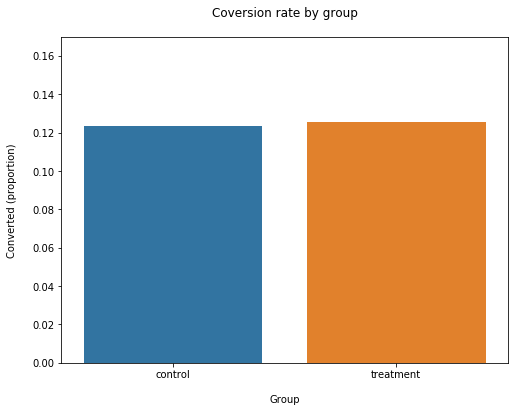

In [22]:
# Looking at the stats, there does not seem to be much of a difference in the conversion rates of the two groups 
# Let's plot to check 

plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'],y=ab_test['converted'],ci=False)
plt.ylim(0,0.17)
plt.title('Coversion rate by group',pad=20)
plt.xlabel("Group",labelpad=15)
plt.ylabel('Converted (proportion)',labelpad=15);

In [24]:
# Now let' test the hypothesis to check of the difference in conversion rates is significantly different 

from statsmodels.stats.proportion import proportions_ztest,proportion_confint

In [25]:
control_results=ab_test[ab_test['group']=='control']['converted']
treatment_results=ab_test[ab_test['group']=='treatment']['converted']

In [28]:
n_con=control_results.count()
n_treat=treatment_results.count()

successes=[control_results.sum(),treatment_results.sum()]
nobs=[n_con,n_treat]

z_stat,pval=proportions_ztest(successes,nobs=nobs)
(lower_con,lower_treat),(upper_con,upper_treat)=proportion_confint(successes,nobs=nobs,alpha=0.5)

print(f'z statistic:{z_stat:.2f}')
print(f'p-value:{pval:.3f}')
print(f'ci 95% for control group:[{lower_con:.3f},{upper_con:.3f}]')
print(f'ci 95% for treatment group:[{lower_treat:.3f},{upper_treat:.3f}]')



z statistic:-0.34
p-value:0.732
ci 95% for control group:[0.120,0.127]
ci 95% for treatment group:[0.122,0.129]


### Conclusion 

In [ ]:
# Since our p-value is very high (0.73), we cannot reject the null hypothesis 
# This means that our new design did not perform significantly different than the old design 